# Notebook Astromark AI

Questo notebook carica i dati dei ticket, li unisce e li preprocessa (utilizzando spaCy per tokenizzazione, lemmatizzazione e NER), costruisce la pipeline di ML, esegue la grid search, salva/carica il modello e infine fornisce un esempio di utilizzo del ticket service.

In [2]:
import sys
import os
import pandas as pd
from service.pipeline import (
    merge_dataframes, 
    dataframe_o3, 
    dataframe_gc, 
    PROCESSED_DATA_PATH, 
    parallel_process_texts, 
    ClassifierType, 
    get_model,
    logger
)

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

### Unione dei dati e preparazione delle variabili  
Questa cella unisce due DataFrame (`dataframe_o3` e `dataframe_gc`) utilizzando la funzione `merge_dataframes`, creando un dataset consolidato.

In [3]:
# Unione dei dati
merged_df = merge_dataframes(dataframe_o3, dataframe_gc)
X = merged_df['titolo_messaggio']
y = merged_df['categoria']
logger.info("Final merged dataset shape: %s", merged_df.shape)

[INFO] Merging dataframes...
[INFO] Eliminated 526 duplicate rows
[INFO] Final merged dataset shape: (5583, 2)


### Visualizzazione della Distribuzione delle Categorie  

Questa cella genera diversi grafici per analizzare la distribuzione delle categorie nel dataset `merged_df`, tra cui un grafico a barre, un grafico a torta, un grafico a barre con percentuali e un box plot della lunghezza del testo.  



Statistiche descrittive per categoria:
categoria
Segreteria    1247
Didattica     1132
Tecnico       1122
Accesso       1050
Profilo       1032
dtype: int64

Percentuali per categoria:
categoria
Segreteria    22.34
Didattica     20.28
Tecnico       20.10
Accesso       18.81
Profilo       18.48
Name: proportion, dtype: float64


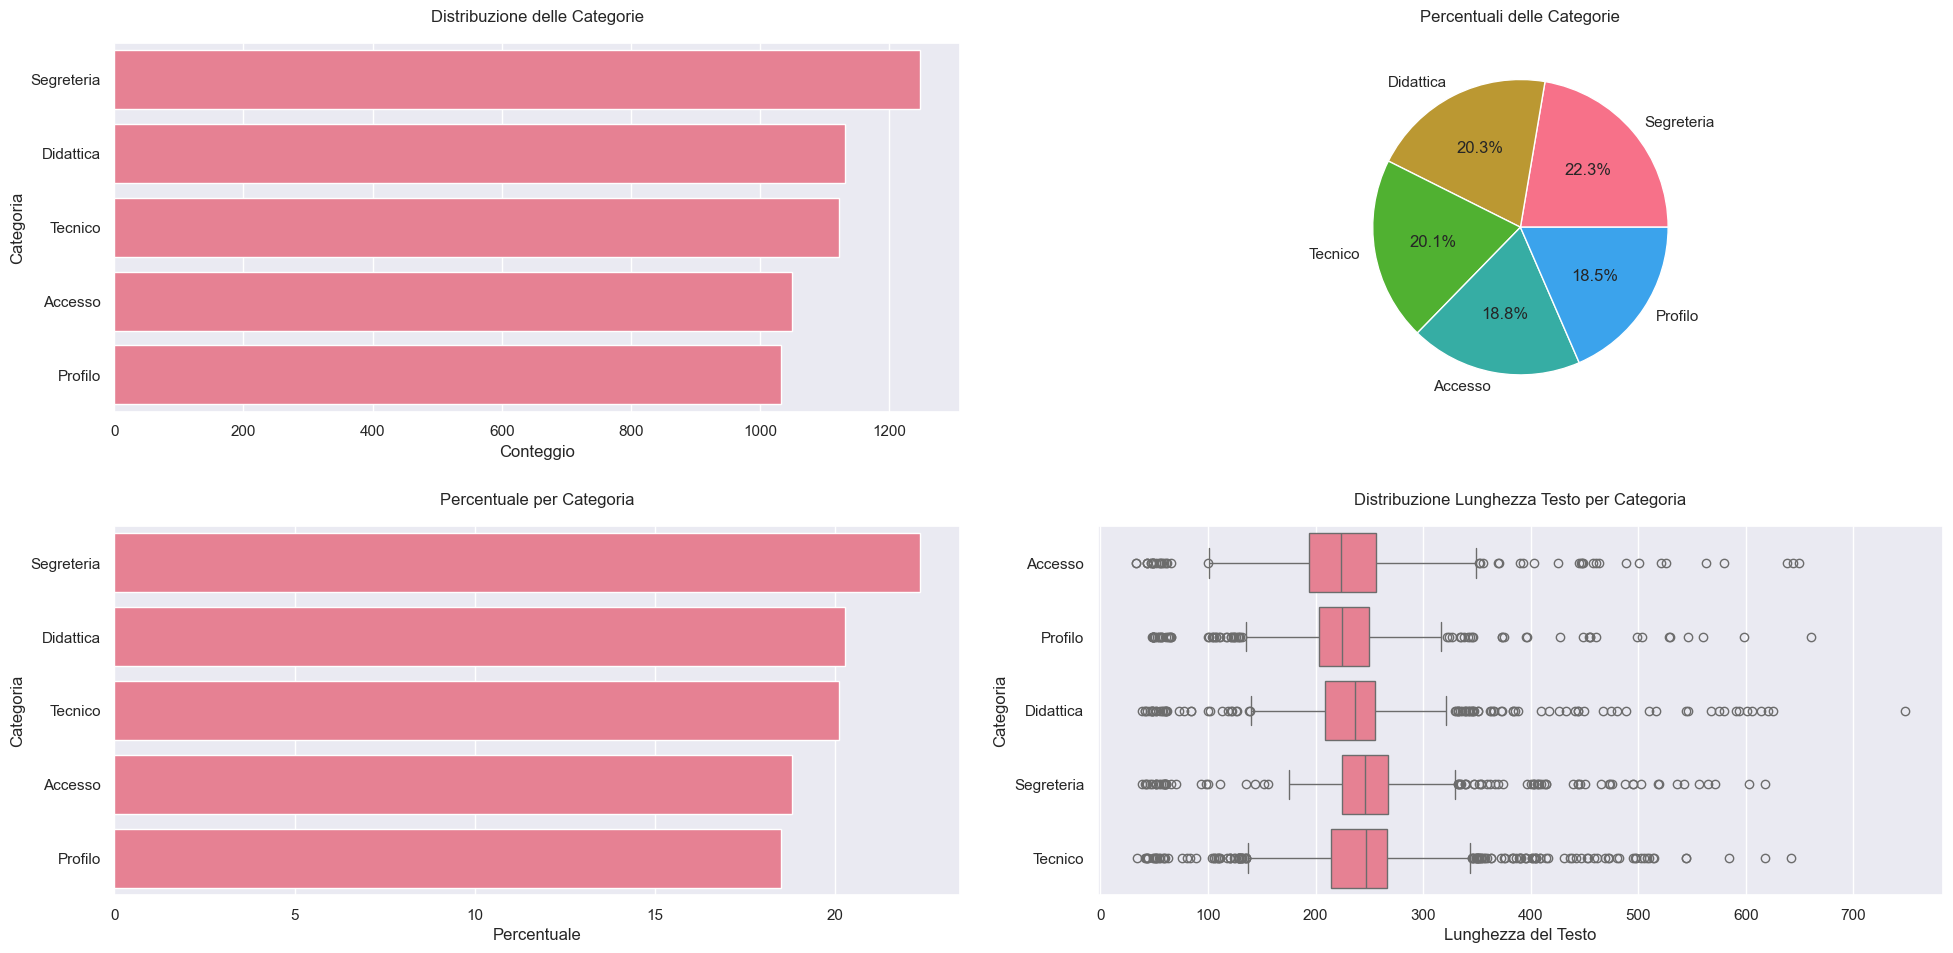

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Impostazioni per una migliore visualizzazione
plt.style.use('default')  # Utilizziamo lo stile default di matplotlib
sns.set_theme()  # Applica il tema base di seaborn
sns.set_palette("husl")

# Creazione di una figura con più sottografici
fig = plt.figure(figsize=(20, 10))

# 1. Grafico a barre della distribuzione delle categorie
plt.subplot(2, 2, 1)
sns.countplot(data=merged_df, y='categoria', order=merged_df['categoria'].value_counts().index)
plt.title('Distribuzione delle Categorie', pad=15)
plt.xlabel('Conteggio')
plt.ylabel('Categoria')

# 2. Grafico a torta delle percentuali
plt.subplot(2, 2, 2)
category_counts = merged_df['categoria'].value_counts()
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
plt.title('Percentuali delle Categorie', pad=15)

# 3. Grafico a barre orizzontale con percentuali
plt.subplot(2, 2, 3)
category_percentages = (merged_df['categoria'].value_counts(normalize=True) * 100)
sns.barplot(x=category_percentages.values, y=category_percentages.index)
plt.title('Percentuale per Categoria', pad=15)
plt.xlabel('Percentuale')
plt.ylabel('Categoria')

# 4. Box plot della lunghezza del testo per categoria
plt.subplot(2, 2, 4)
merged_df['text_length'] = merged_df['titolo_messaggio'].str.len()
sns.boxplot(data=merged_df, x='text_length', y='categoria')
plt.title('Distribuzione Lunghezza Testo per Categoria', pad=15)
plt.xlabel('Lunghezza del Testo')
plt.ylabel('Categoria')

# Aggiusta il layout
plt.tight_layout(pad=2.0)

# Mostra statistiche descrittive
print("\nStatistiche descrittive per categoria:")
print(merged_df.groupby('categoria').size().sort_values(ascending=False))
print("\nPercentuali per categoria:")
print(category_percentages.round(2))

# Mostra il plot
plt.show()

### Caricamento o Preprocessing dei Dati  

Questa cella verifica se i dati preprocessati sono già disponibili e, in caso contrario, li elabora e li salva.  


In [5]:
# Carica o processa i dati preprocessati
if os.path.exists(PROCESSED_DATA_PATH):
    logger.info("Loading preprocessed data from '%s'...", PROCESSED_DATA_PATH)
    df = pd.read_csv(PROCESSED_DATA_PATH)
    X_processed = df["processed_text"]
else:
    logger.info("Preprocessed data not found, starting parallel preprocessing...")
    X_processed = parallel_process_texts(X, n_jobs=-1)
    logger.info("Saving preprocessed data to: %s", PROCESSED_DATA_PATH)
    X_processed_df = pd.DataFrame(X_processed, columns=["processed_text"])
    X_processed_df.to_csv(PROCESSED_DATA_PATH, index=False)
    logger.info("Preprocessing complete and cached.")

[INFO] Loading preprocessed data from 'H:\Informatica\astromark-ai\service\..\data\processed\X_processed.csv'...


## Fine della Pipeline

I dati sono stati caricati, preprocessati e il modello (ottenuto tramite Grid Search) è stato caricato o addestrato e salvato nella cartella `../data/trained`
#### Monitoraggio delle Risorse (CPU e Memoria) Durante l'Addestramento di Naive Bayes

Questa cella misura l'**andamento dell'uso della CPU e della memoria RAM** durante l'addestramento del classificatore **Naive Bayes**.  


[INFO] Measuring CPU & RAM usage while training naive_bayes...
[INFO] CPU & RAM usage measurement complete.
[INFO] Training finished in 3.37 seconds.
[INFO] Best parameters for naive_bayes: {'clf__alpha': 1.0, 'tfidf__max_df': 0.85, 'tfidf__min_df': 1}


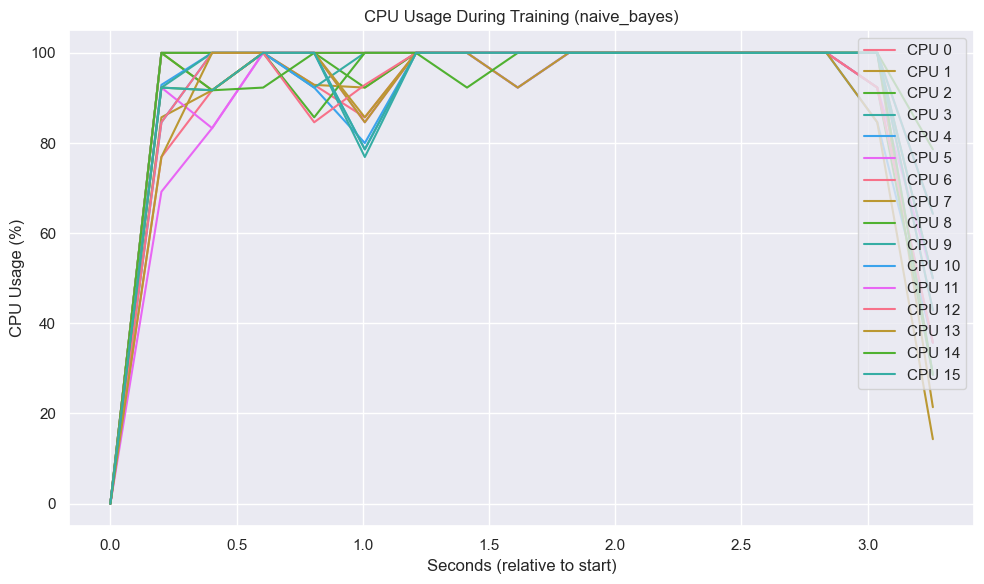

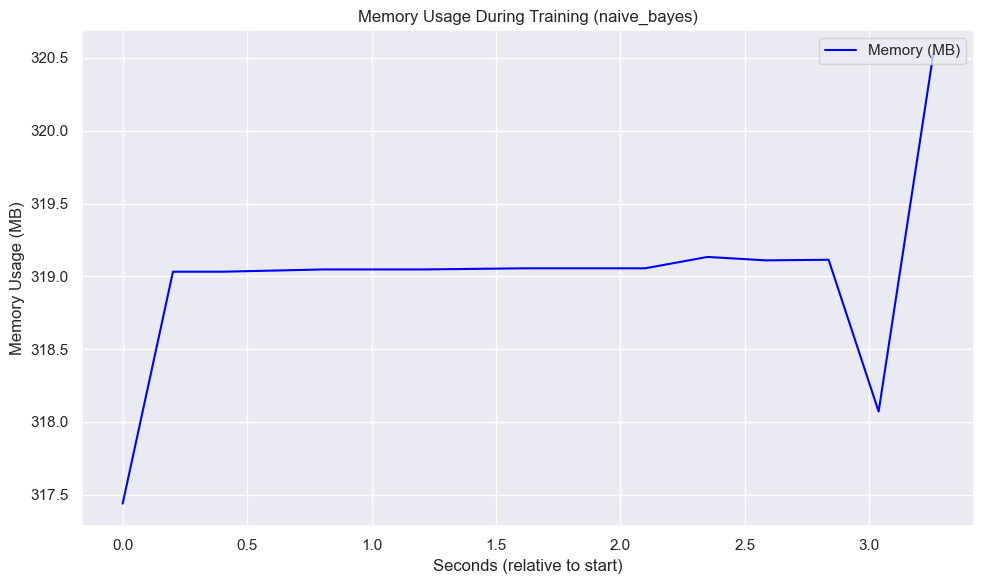

[INFO] Model saved to H:\Informatica\astromark-ai\service\..\data\trained\trained_model_nb.pkl.


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.85, max_features=3000,
                                 ngram_range=(1, 2), sublinear_tf=True)),
                ('clf', MultinomialNB())])

In [6]:
from service.report_predict import evaluate_model_with_kfold
from service.pipeline import measure_pc_metrics_during_training
measure_pc_metrics_during_training(ClassifierType.NAIVE_BAYES, save_plot=False)

### Valutazione del Modello Naive Bayes con K-Fold Cross-Validation  

Questa cella esegue una **validazione incrociata (K-Fold cross-validation)** per il classificatore **Naive Bayes**, utilizzando il dataset `X_processed` per le caratteristiche e `y` per le etichette.  


[INFO] Loading saved model from H:\Informatica\astromark-ai\service\..\data\trained\trained_model_nb.pkl...
[INFO] Using saved model for naive_bayes.
[INFO] === Fold 1/5 ===
[INFO] === Fold 2/5 ===
[INFO] === Fold 3/5 ===
[INFO] === Fold 4/5 ===
[INFO] === Fold 5/5 ===


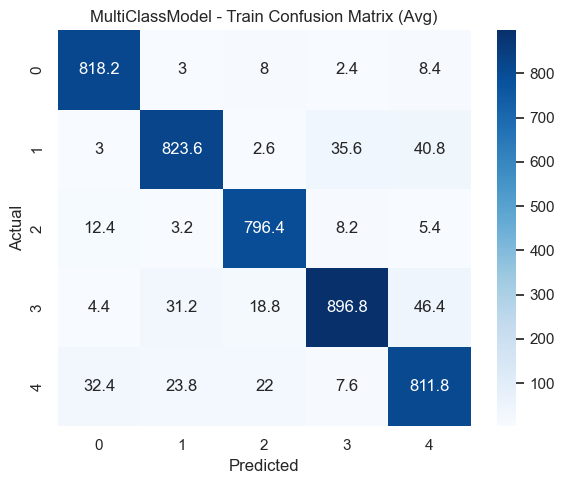

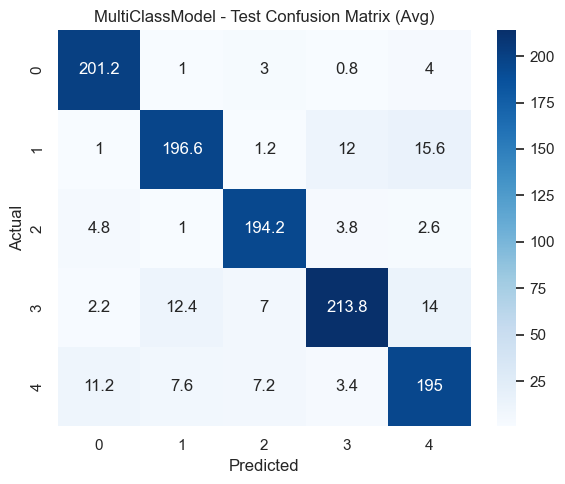

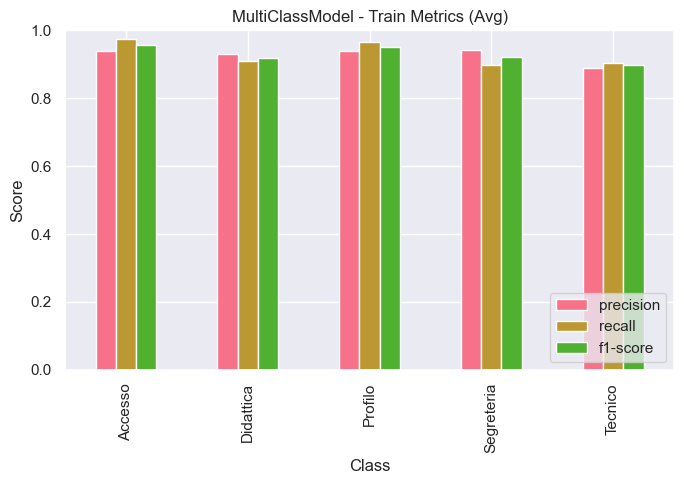

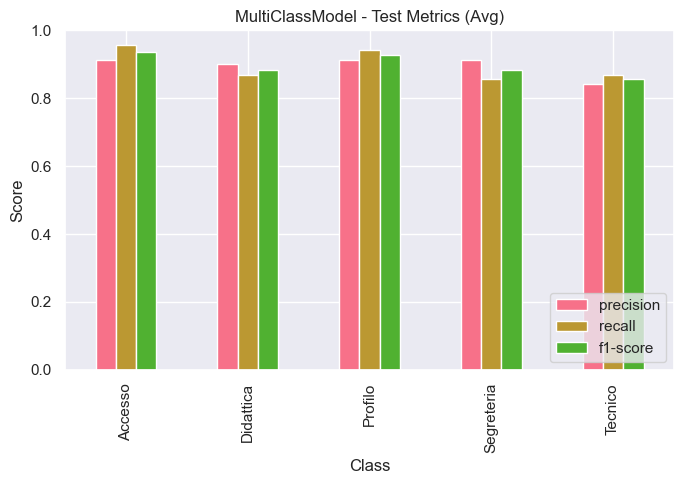

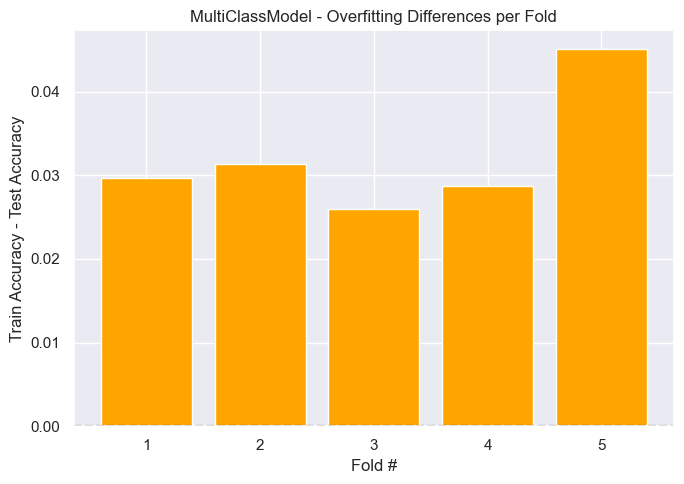

{'train': {'accuracy': 0.9284434060956143,
  'confusion_matrix': array([[818.2,   3. ,   8. ,   2.4,   8.4],
         [  3. , 823.6,   2.6,  35.6,  40.8],
         [ 12.4,   3.2, 796.4,   8.2,   5.4],
         [  4.4,  31.2,  18.8, 896.8,  46.4],
         [ 32.4,  23.8,  22. ,   7.6, 811.8]]),
  'report_df':               precision    recall  f1-score      support
  Accesso        0.940027  0.974046  0.956733   840.000000
  Didattica      0.930917  0.909426  0.920025   905.600000
  Profilo        0.939385  0.964611  0.951826   825.600000
  Segreteria     0.943361  0.898906  0.920591   997.600000
  Tecnico        0.889431  0.904385  0.896831   897.600000
  accuracy       0.928443  0.928443  0.928443     0.928443
  macro avg      0.928624  0.930275  0.929201  4466.400000
  weighted avg   0.928636  0.928443  0.928285  4466.400000},
 'test': {'accuracy': 0.8962909482966086,
  'confusion_matrix': array([[201.2,   1. ,   3. ,   0.8,   4. ],
         [  1. , 196.6,   1.2,  12. ,  15.6],
     

In [7]:
evaluate_model_with_kfold(get_model(ClassifierType.NAIVE_BAYES), X_processed, y)

### Monitoraggio delle Risorse (CPU e Memoria) Durante l'Addestramento di SVM

Questa cella misura l'**andamento dell'uso della CPU e della memoria RAM** durante l'addestramento del classificatore **SVM**.  


[INFO] Measuring CPU & RAM usage while training svm...
[INFO] CPU & RAM usage measurement complete.
[INFO] Training finished in 233.13 seconds.
[INFO] Best parameters for svm: {'clf__C': 2.0, 'svd__n_components': 150, 'tfidf__max_df': 0.85, 'tfidf__min_df': 3}


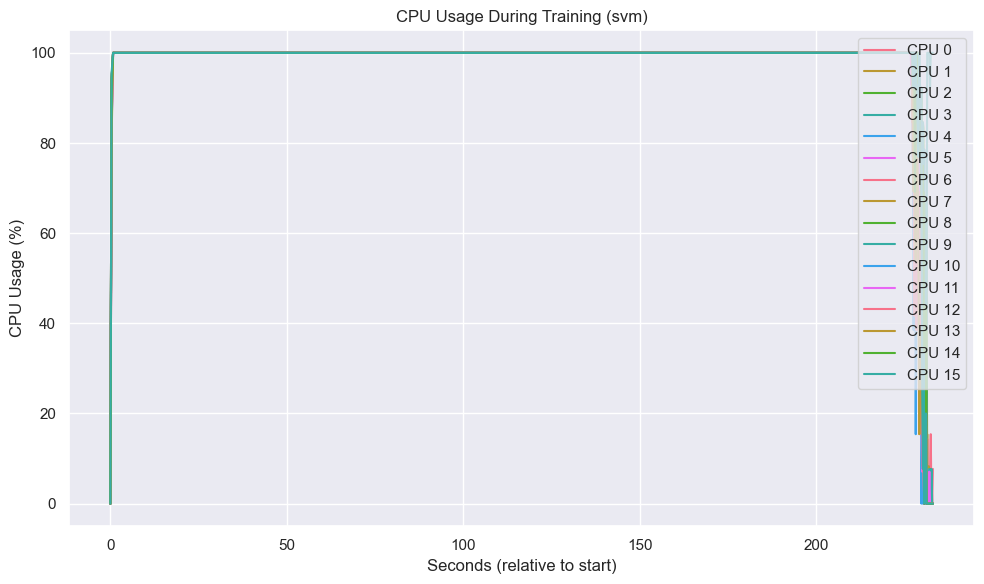

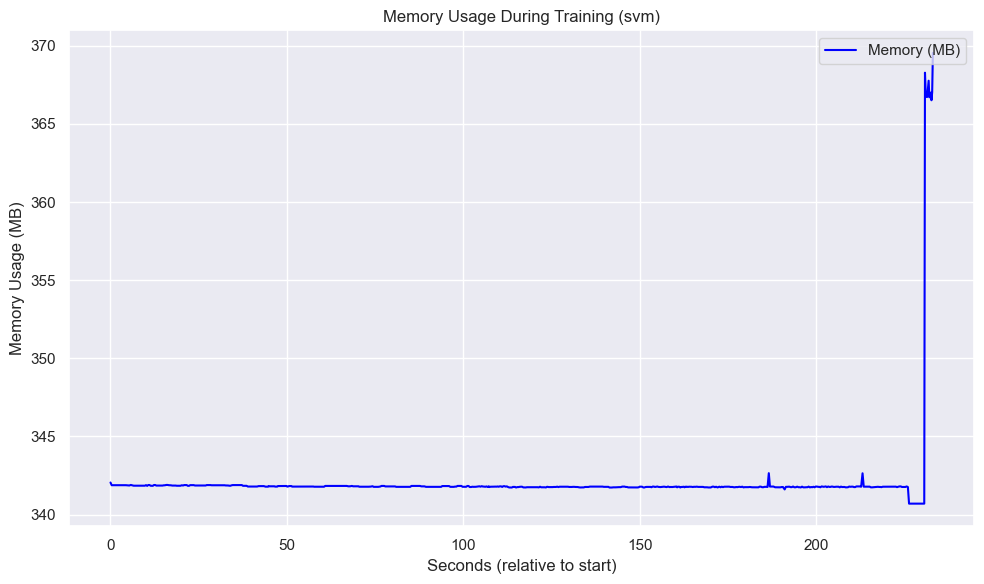

[INFO] Model saved to H:\Informatica\astromark-ai\service\..\data\trained\trained_model_svm.pkl.


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.85, max_features=3000, min_df=3,
                                 ngram_range=(1, 2), sublinear_tf=True)),
                ('svd', TruncatedSVD(n_components=150, random_state=42)),
                ('clf',
                 SVC(C=2.0, kernel='linear', probability=True,
                     random_state=42))])

In [8]:
measure_pc_metrics_during_training(ClassifierType.SVM, save_plot=False)

### Valutazione del Modello SVM con K-Fold Cross-Validation  

Questa cella esegue una **validazione incrociata (K-Fold cross-validation)** per il classificatore **SVM**, utilizzando il dataset `X_processed` per le caratteristiche e `y` per le etichette. 

[INFO] Loading saved model from H:\Informatica\astromark-ai\service\..\data\trained\trained_model_svm.pkl...
[INFO] Using saved model for svm.
[INFO] === Fold 1/5 ===
[INFO] === Fold 2/5 ===
[INFO] === Fold 3/5 ===
[INFO] === Fold 4/5 ===
[INFO] === Fold 5/5 ===


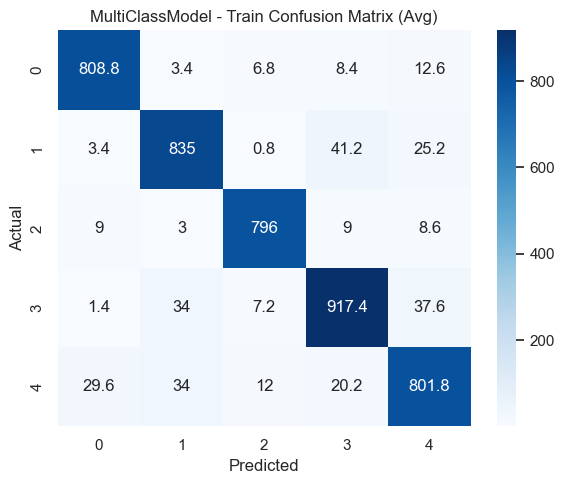

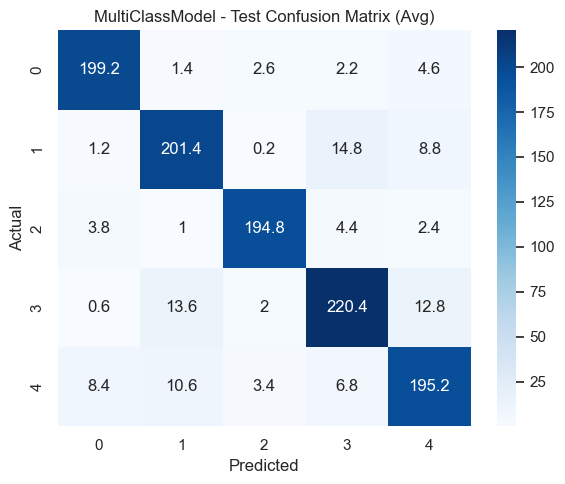

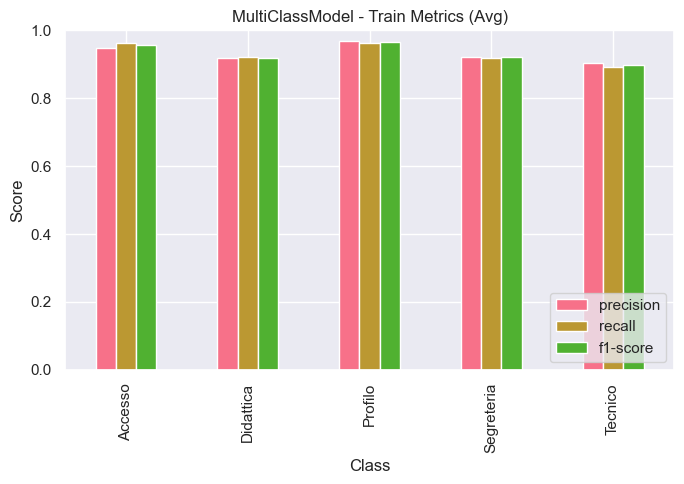

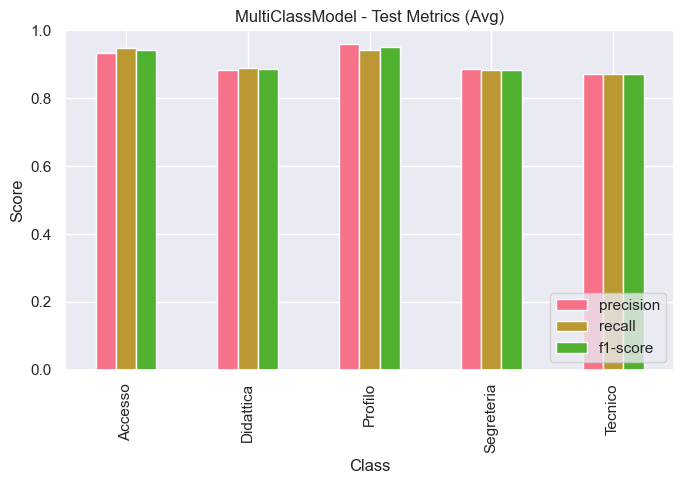

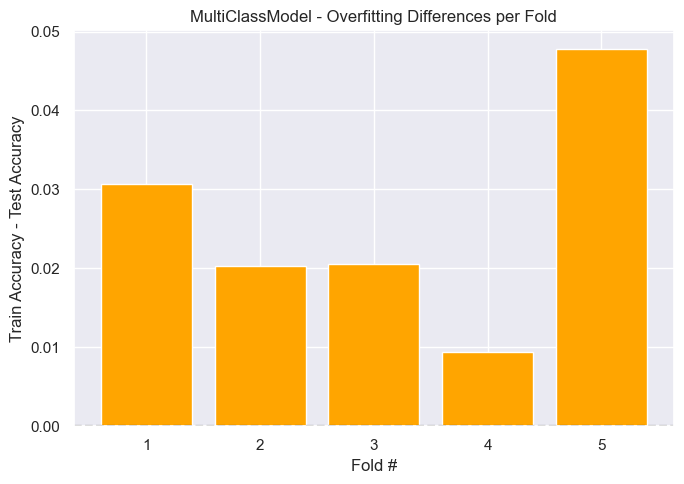

{'train': {'accuracy': 0.9311750167496907,
  'confusion_matrix': array([[8.088e+02, 3.400e+00, 6.800e+00, 8.400e+00, 1.260e+01],
         [3.400e+00, 8.350e+02, 8.000e-01, 4.120e+01, 2.520e+01],
         [9.000e+00, 3.000e+00, 7.960e+02, 9.000e+00, 8.600e+00],
         [1.400e+00, 3.400e+01, 7.200e+00, 9.174e+02, 3.760e+01],
         [2.960e+01, 3.400e+01, 1.200e+01, 2.020e+01, 8.018e+02]]),
  'report_df':               precision    recall  f1-score      support
  Accesso        0.949099  0.962851  0.955908   840.000000
  Didattica      0.918218  0.922025  0.920108   905.600000
  Profilo        0.967421  0.964116  0.965763   825.600000
  Segreteria     0.920955  0.919516  0.920212   997.600000
  Tecnico        0.905175  0.893320  0.899203   897.600000
  accuracy       0.931175  0.931175  0.931175     0.931175
  macro avg      0.932173  0.932365  0.932239  4466.400000
  weighted avg   0.931101  0.931175  0.931107  4466.400000},
 'test': {'accuracy': 0.905426080483117,
  'confusion_matri

In [9]:
evaluate_model_with_kfold(get_model(ClassifierType.SVM), X_processed, y)

### Confronto tra Classificatori Naive Bayes e SVM con K-Fold Cross-Validation  

Questa cella esegue un **confronto tra due classificatori** (Naive Bayes e SVM) utilizzando la **validazione incrociata K-Fold** su tutto il dataset preprocessato. I risultati vengono calcolati per ogni fold e vengono comparati per determinare quale classificatore offre le migliori prestazioni.  


[INFO] Starting K-Fold comparison of Naive Bayes vs. SVM...
[INFO] Comparing Naive Bayes vs. SVM with 5-fold cross-validation...
[INFO] Loading saved model from H:\Informatica\astromark-ai\service\..\data\trained\trained_model_nb.pkl...
[INFO] Using saved model for naive_bayes.
[INFO] Loading saved model from H:\Informatica\astromark-ai\service\..\data\trained\trained_model_svm.pkl...
[INFO] Using saved model for svm.
[INFO] Evaluating Naive Bayes with KFold...
[INFO] === Fold 1/5 ===
[INFO] === Fold 2/5 ===
[INFO] === Fold 3/5 ===
[INFO] === Fold 4/5 ===
[INFO] === Fold 5/5 ===


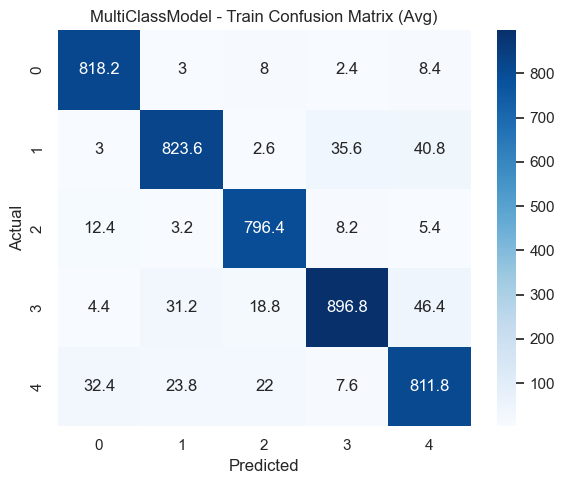

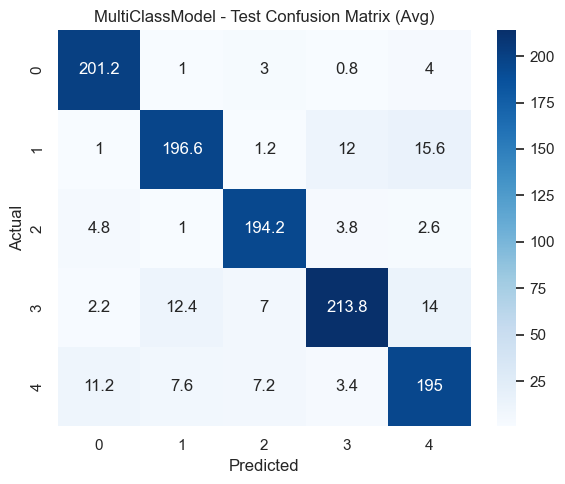

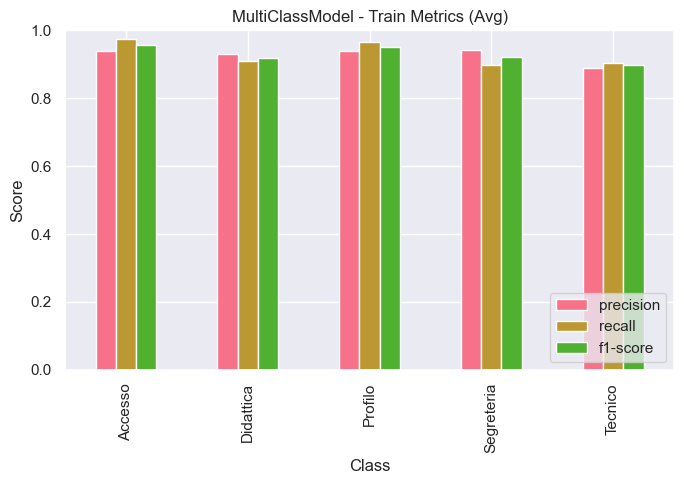

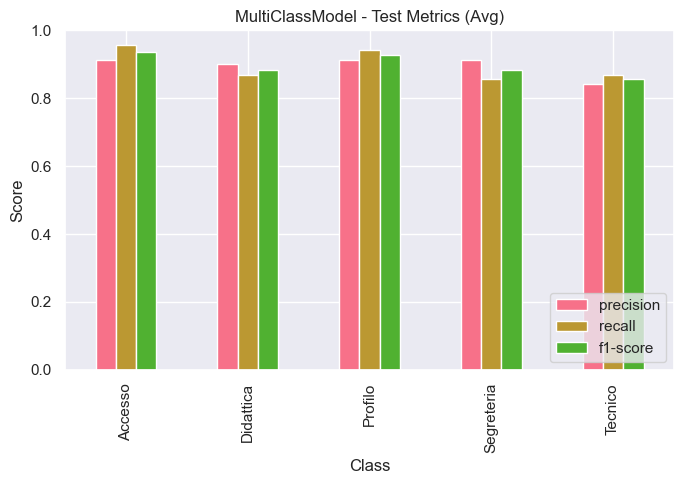

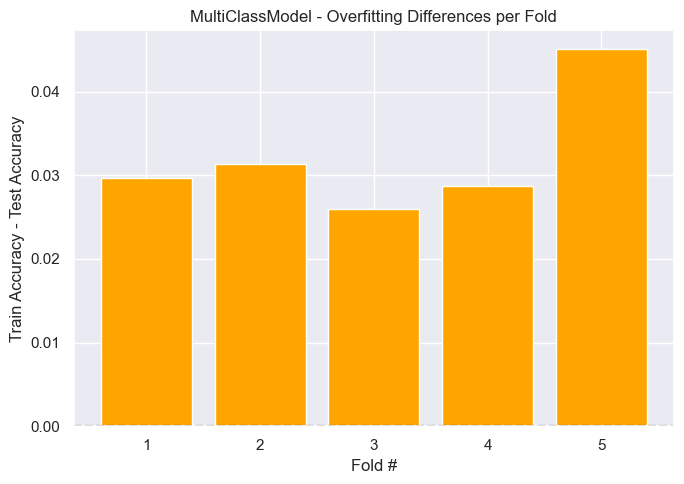

[INFO] Evaluating SVM with KFold...
[INFO] === Fold 1/5 ===
[INFO] === Fold 2/5 ===
[INFO] === Fold 3/5 ===
[INFO] === Fold 4/5 ===
[INFO] === Fold 5/5 ===


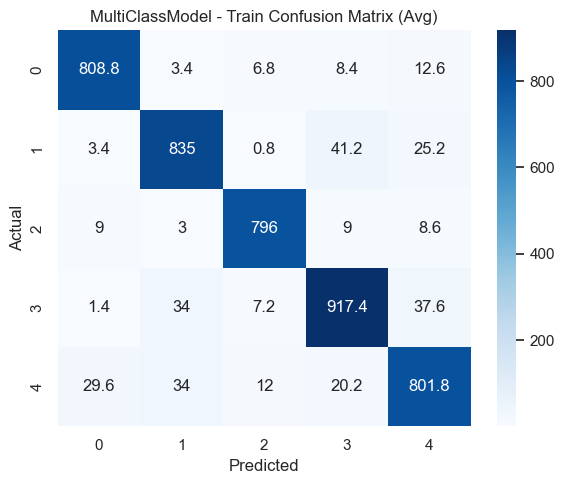

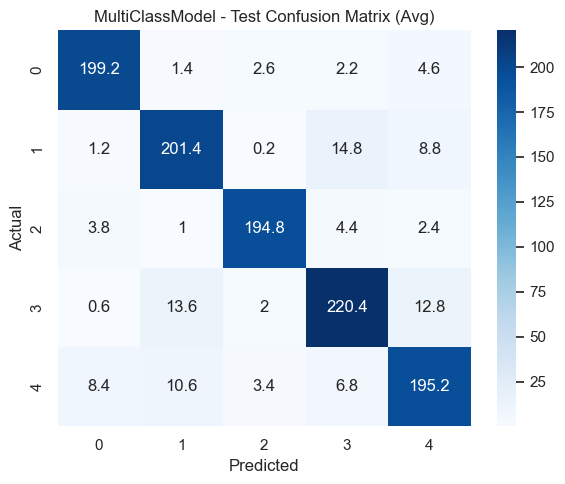

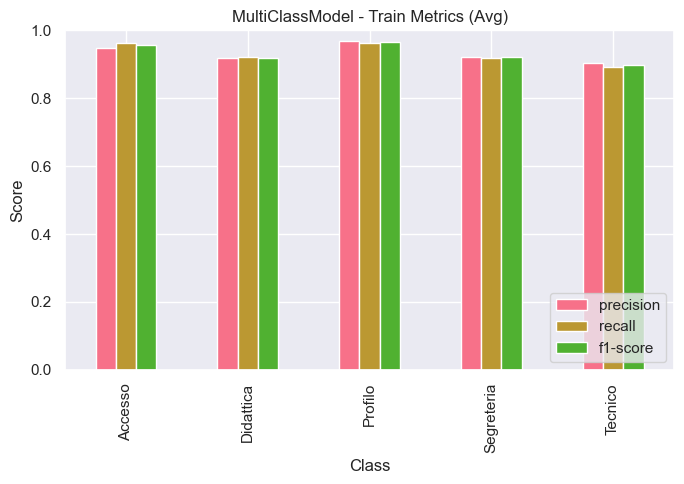

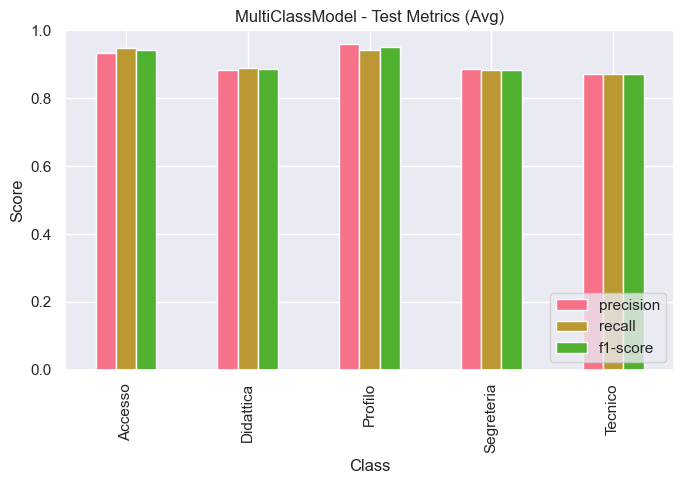

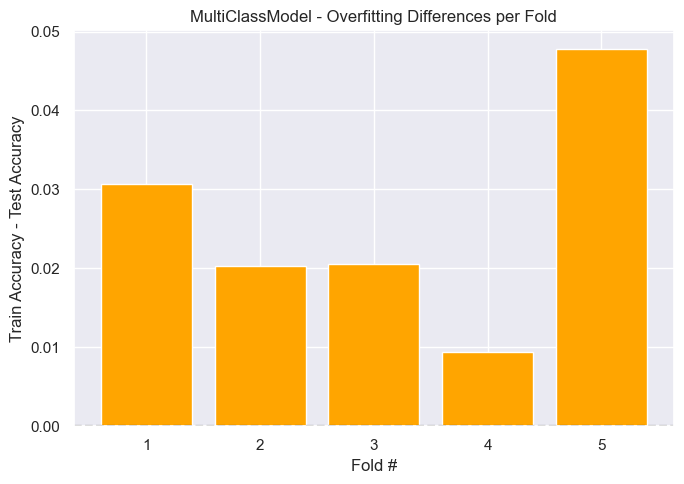

[INFO] KFold Comparison:
 Classifier  Train Accuracy  Test Accuracy  Overfitting (Train-Test)
Naive_Bayes        0.928443       0.896291                  0.032152
        SVM        0.931175       0.905426                  0.025749


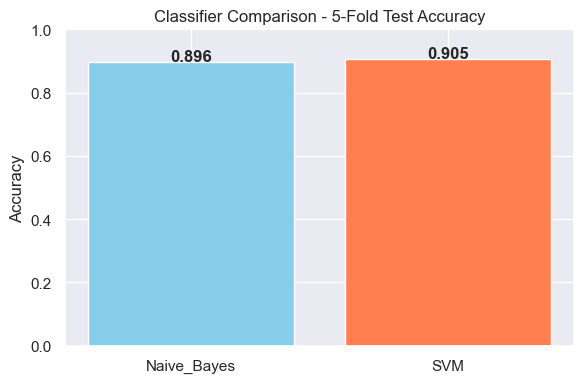

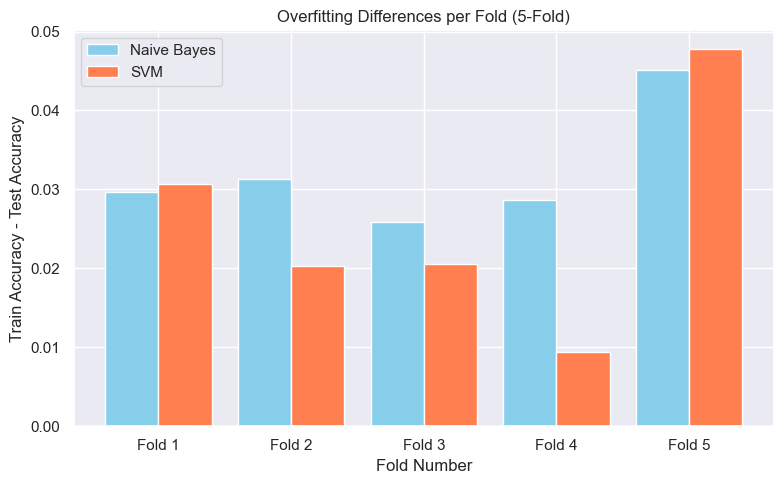

Comparison Results (Naive Bayes vs. SVM):


' Classifier  Train Accuracy  Test Accuracy  Overfitting (Train-Test)\nNaive_Bayes        0.928443       0.896291                  0.032152\n        SVM        0.931175       0.905426                  0.025749'

In [10]:
from service.report_predict import compare_classifiers_with_kfold

# Example usage of compare_classifiers_with_kfold
logger.info("Starting K-Fold comparison of Naive Bayes vs. SVM...")

# Use the entire preprocessed dataset
X_small, y_small = X_processed, y

# Compare the two classifiers with 5-fold CV,
# saving both the plots and the resulting DataFrame.
df_results = compare_classifiers_with_kfold(
    X_small,
    y_small,
    n_splits=5,
    shuffle=True,
    random_state=42,
    save_plots=False,  # True -> saves bar charts
    save_data=False  # True -> saves the final df_compare to CSV
)

print("Comparison Results (Naive Bayes vs. SVM):")
df_results.to_string(index=False)

## Fase di Controllo e Valutazione Completata - Passiamo all'Utilizzo del Dataset
Esempio di Funzione del Ticket Service: classificazione del Messaggio

In [11]:
# Esempio: Funzione per il Ticket Service
def ticket_service(title, message, classifier_type):
    get_model(classifier_type)
    full_text = f"{title} {message}".strip()
    if not full_text:
        return ["Nessun input fornito"]
    # Importa la funzione predict_category dal modulo report_predict
    from service.report_predict import predict_category
    predictions = predict_category(full_text, classifier_type)
    print("Predizioni:", predictions)
    return predictions

### Esempio di utilizzo con SVM

In [12]:
example_title = "Problema con la stampante"
example_message = "La stampante non funziona correttamente."
pd.DataFrame(ticket_service(example_title, example_message, ClassifierType.SVM), columns=["Class", "Probability"])

[INFO] Loading saved model from H:\Informatica\astromark-ai\service\..\data\trained\trained_model_svm.pkl...
[INFO] Using saved model for svm.
[INFO] Predicting category for a new message...
[INFO] Loading saved model from H:\Informatica\astromark-ai\service\..\data\trained\trained_model_svm.pkl...
[INFO] Using saved model for svm.


Predizioni: [('Tecnico', 0.9792899195443923), ('Segreteria', 0.012047288018136993), ('Accesso', 0.004744532611799294)]


,Class,Probability
0,Tecnico,0.979290
1,Segreteria,0.012047
2,Accesso,0.004745


### Esempio di utilizzo con NAIVE BAYES

In [13]:
example_title = "Problema con la stampante"
example_message = "La stampante non funziona correttamente."
pd.DataFrame(ticket_service(example_title, example_message, ClassifierType.NAIVE_BAYES), columns=["Class", "Probability"])

[INFO] Loading saved model from H:\Informatica\astromark-ai\service\..\data\trained\trained_model_nb.pkl...
[INFO] Using saved model for naive_bayes.
[INFO] Predicting category for a new message...
[INFO] Loading saved model from H:\Informatica\astromark-ai\service\..\data\trained\trained_model_nb.pkl...
[INFO] Using saved model for naive_bayes.


Predizioni: [('Tecnico', 0.8143120993439009), ('Accesso', 0.07643040095847116), ('Didattica', 0.03966360187571124)]


,Class,Probability
0,Tecnico,0.814312
1,Accesso,0.076430
2,Didattica,0.039664


## Analisi del Fenomeno di Hughes con TruncatedSVD

In questa sezione del notebook viene eseguita un'analisi per studiare l'effetto della variazione del numero di componenti del **TruncatedSVD** sulle performance del modello SVM. Utilizzando la funzione `plot_hughes_phenomenon_truncated_svd_fixed` importata dal modulo `service.report_predict`, il codice applica una validazione incrociata a 5 fold sul dataset ridotto (`X_small` e `y_small`).

In particolare, la funzione testa cinque specifici valori di componenti (200, 500, 1000, 2000, 3000) e calcola l'accuratezza media sui dati di training e di test per ciascun valore. Questo grafico permette di osservare il fenomeno di Hughes, evidenziando come la scelta del numero di componenti possa influenzare la capacità del modello di generalizzare, aiutandoci a individuare un possibile punto ottimale in cui bilanciare la complessità del modello e le sue performance.


[INFO] Creating Hughes Phenomenon graph for fixed TruncatedSVD components: 100, 200, 500, 1000, 2000...


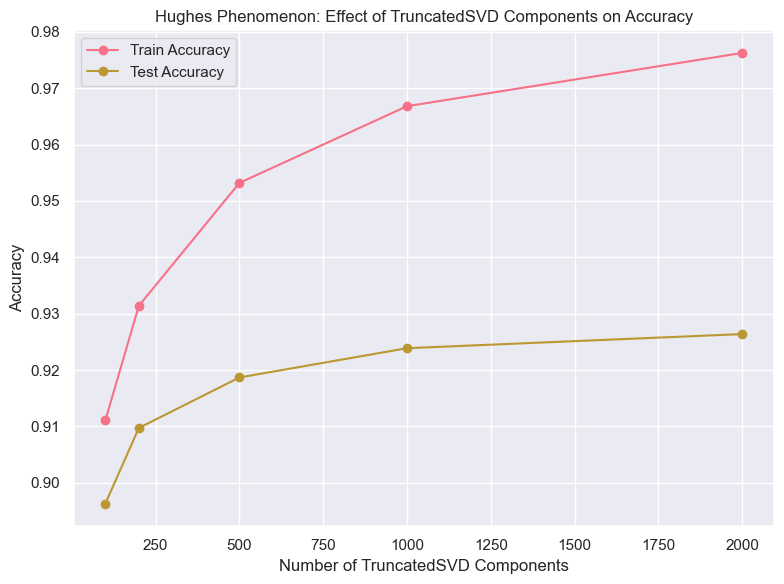

[INFO] Hughes Phenomenon graph created with components [100, 200, 500, 1000, 2000].


In [14]:
from service.report_predict import plot_hughes_phenomenon_truncated_svd_fixed
plot_hughes_phenomenon_truncated_svd_fixed(
    X_small,
    y_small,
    n_splits=5,
)

# Valutazione del Modello Word2Vec con Cross-Validation a 5 Fold

In questa sezione valutiamo un modello di classificazione testuale basato su Word2Vec, utilizzando una procedura di cross-validation a 5 fold con un classificatore SVM.

**Cosa fa il codice:**
- **Calcolo delle Metriche:** Vengono calcolate e stampate le metriche principali per ogni fold, quali:
  - Accuratezza (accuracy)
  - Matrice di Confusione
  - Classification Report (precision, recall, f1-score)
- **Aggregazione dei Risultati:** Al termine della validazione, le metriche dei vari fold vengono aggregate per fornire una panoramica complessiva delle performance del modello.

In [15]:
from service.word2vec_pipeline import evaluate_word2vec_model_kfold

evaluate_word2vec_model_kfold(ClassifierType.SVM, X, y)

[INFO] No saved Word2Vec model found for svm. Training a new one...


=== Fold 1 ===


[INFO] collecting all words and their counts
[INFO] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
[INFO] collected 4562 word types from a corpus of 109607 raw words and 5583 sentences
[INFO] Creating a fresh vocabulary
[INFO] Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 4562 unique words (100.00% of original 4562, drops 0)', 'datetime': '2025-02-09T09:56:17.679889', 'gensim': '4.3.3', 'python': '3.12.8 (tags/v3.12.8:2dc476b, Dec  3 2024, 19:30:04) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
[INFO] Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 109607 word corpus (100.00% of original 109607, drops 0)', 'datetime': '2025-02-09T09:56:17.679889', 'gensim': '4.3.3', 'python': '3.12.8 (tags/v3.12.8:2dc476b, Dec  3 2024, 19:30:04) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
[INFO] deleting the raw counts dictionary of 4562 items
[INFO

Train Accuracy: 0.7026
Test Accuracy:  0.6831
Confusion Matrix:
 [[163   6   9  12  23]
 [ 14 144   1  41  41]
 [ 17   7 172  10   9]
 [ 12  30   3 150  35]
 [ 25  23   8  28 134]]
Classification Report:
  Accesso: {'precision': 0.7056277056277056, 'recall': 0.7652582159624414, 'f1-score': 0.7342342342342343, 'support': 213.0}
  Didattica: {'precision': 0.6857142857142857, 'recall': 0.5975103734439834, 'f1-score': 0.6385809312638581, 'support': 241.0}
  Profilo: {'precision': 0.8911917098445595, 'recall': 0.8, 'f1-score': 0.8431372549019608, 'support': 215.0}
  Segreteria: {'precision': 0.6224066390041494, 'recall': 0.6521739130434783, 'f1-score': 0.6369426751592356, 'support': 230.0}
  Tecnico: {'precision': 0.5537190082644629, 'recall': 0.6146788990825688, 'f1-score': 0.5826086956521739, 'support': 218.0}
  accuracy: 0.6830796777081468
  macro avg: {'precision': 0.6917318696910326, 'recall': 0.6859242803064944, 'f1-score': 0.6871007582422924, 'support': 1117.0}
  weighted avg: {'prec

[INFO] EPOCH 0: training on 152154 raw words (120673 effective words) took 0.0s, 3153852 effective words/s
[INFO] EPOCH 1: training on 152154 raw words (120766 effective words) took 0.0s, 3119674 effective words/s
[INFO] EPOCH 2: training on 152154 raw words (120821 effective words) took 0.0s, 3189008 effective words/s
[INFO] EPOCH 3: training on 152154 raw words (120833 effective words) took 0.0s, 3387287 effective words/s
[INFO] EPOCH 4: training on 152154 raw words (120858 effective words) took 0.0s, 3274016 effective words/s
[INFO] Word2Vec lifecycle event {'msg': 'training on 760770 raw words (603951 effective words) took 0.2s, 2692775 effective words/s', 'datetime': '2025-02-09T09:56:22.189297', 'gensim': '4.3.3', 'python': '3.12.8 (tags/v3.12.8:2dc476b, Dec  3 2024, 19:30:04) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'train'}
[INFO] Word2Vec lifecycle event {'params': 'Word2Vec<vocab=11433, vector_size=50, alpha=0.025>', 'datetime': '2025-02

Train Accuracy: 0.6970
Test Accuracy:  0.7046
Confusion Matrix:
 [[152   2  15   9  29]
 [  6 161   4  22  26]
 [ 11   8 176   5  11]
 [ 13  35   9 151  42]
 [ 34  19   7  23 147]]
Classification Report:
  Accesso: {'precision': 0.7037037037037037, 'recall': 0.7342995169082126, 'f1-score': 0.7186761229314421, 'support': 207.0}
  Didattica: {'precision': 0.7155555555555555, 'recall': 0.7351598173515982, 'f1-score': 0.7252252252252253, 'support': 219.0}
  Profilo: {'precision': 0.8341232227488151, 'recall': 0.8341232227488151, 'f1-score': 0.8341232227488151, 'support': 211.0}
  Segreteria: {'precision': 0.719047619047619, 'recall': 0.604, 'f1-score': 0.6565217391304348, 'support': 250.0}
  Tecnico: {'precision': 0.5764705882352941, 'recall': 0.6391304347826087, 'f1-score': 0.6061855670103092, 'support': 230.0}
  accuracy: 0.7045658012533572
  macro avg: {'precision': 0.7097801378581975, 'recall': 0.709342598358247, 'f1-score': 0.7081463754092453, 'support': 1117.0}
  weighted avg: {'prec

[INFO] EPOCH 0: training on 152572 raw words (121104 effective words) took 0.0s, 3050164 effective words/s
[INFO] EPOCH 1: training on 152572 raw words (121084 effective words) took 0.0s, 3204756 effective words/s
[INFO] EPOCH 2: training on 152572 raw words (121123 effective words) took 0.0s, 2932817 effective words/s
[INFO] EPOCH 3: training on 152572 raw words (121029 effective words) took 0.0s, 3232414 effective words/s
[INFO] EPOCH 4: training on 152572 raw words (121128 effective words) took 0.0s, 3095164 effective words/s
[INFO] Word2Vec lifecycle event {'msg': 'training on 762860 raw words (605468 effective words) took 0.2s, 2629754 effective words/s', 'datetime': '2025-02-09T09:56:24.710957', 'gensim': '4.3.3', 'python': '3.12.8 (tags/v3.12.8:2dc476b, Dec  3 2024, 19:30:04) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'train'}
[INFO] Word2Vec lifecycle event {'params': 'Word2Vec<vocab=11422, vector_size=50, alpha=0.025>', 'datetime': '2025-02

Train Accuracy: 0.7060
Test Accuracy:  0.6759
Confusion Matrix:
 [[149   1   9  12  37]
 [  5 135   6  32  49]
 [ 11  11 171   5  13]
 [ 14  32   4 152  34]
 [ 28  25   6  28 148]]
Classification Report:
  Accesso: {'precision': 0.7198067632850241, 'recall': 0.7163461538461539, 'f1-score': 0.7180722891566265, 'support': 208.0}
  Didattica: {'precision': 0.6617647058823529, 'recall': 0.5947136563876652, 'f1-score': 0.6264501160092807, 'support': 227.0}
  Profilo: {'precision': 0.8724489795918368, 'recall': 0.8104265402843602, 'f1-score': 0.8402948402948403, 'support': 211.0}
  Segreteria: {'precision': 0.6637554585152838, 'recall': 0.6440677966101694, 'f1-score': 0.6537634408602151, 'support': 236.0}
  Tecnico: {'precision': 0.5266903914590747, 'recall': 0.6297872340425532, 'f1-score': 0.5736434108527132, 'support': 235.0}
  accuracy: 0.67591763652641
  macro avg: {'precision': 0.6888932597467146, 'recall': 0.6790682762341803, 'f1-score': 0.6824448194347352, 'support': 1117.0}
  weighte

[INFO] EPOCH 0: training on 151975 raw words (120358 effective words) took 0.0s, 2990194 effective words/s
[INFO] EPOCH 1: training on 151975 raw words (120564 effective words) took 0.0s, 3229214 effective words/s
[INFO] EPOCH 2: training on 151975 raw words (120605 effective words) took 0.0s, 3206250 effective words/s
[INFO] EPOCH 3: training on 151975 raw words (120258 effective words) took 0.0s, 3486548 effective words/s
[INFO] EPOCH 4: training on 151975 raw words (120478 effective words) took 0.0s, 3339589 effective words/s
[INFO] Word2Vec lifecycle event {'msg': 'training on 759875 raw words (602263 effective words) took 0.2s, 2749250 effective words/s', 'datetime': '2025-02-09T09:56:27.201590', 'gensim': '4.3.3', 'python': '3.12.8 (tags/v3.12.8:2dc476b, Dec  3 2024, 19:30:04) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'train'}
[INFO] Word2Vec lifecycle event {'params': 'Word2Vec<vocab=11470, vector_size=50, alpha=0.025>', 'datetime': '2025-02

Train Accuracy: 0.6938
Test Accuracy:  0.7088
Confusion Matrix:
 [[156   6  16   3  30]
 [  4 145   3  32  42]
 [ 11  10 175   3   6]
 [  5  34   3 181  42]
 [ 29  27   6  13 134]]
Classification Report:
  Accesso: {'precision': 0.7609756097560976, 'recall': 0.7393364928909952, 'f1-score': 0.75, 'support': 211.0}
  Didattica: {'precision': 0.6531531531531531, 'recall': 0.6415929203539823, 'f1-score': 0.6473214285714286, 'support': 226.0}
  Profilo: {'precision': 0.8620689655172413, 'recall': 0.8536585365853658, 'f1-score': 0.8578431372549019, 'support': 205.0}
  Segreteria: {'precision': 0.7801724137931034, 'recall': 0.6830188679245283, 'f1-score': 0.7283702213279678, 'support': 265.0}
  Tecnico: {'precision': 0.5275590551181102, 'recall': 0.6411483253588517, 'f1-score': 0.5788336933045356, 'support': 209.0}
  accuracy: 0.7087813620071685
  macro avg: {'precision': 0.7167858394675412, 'recall': 0.7117510286227446, 'f1-score': 0.7124736960917668, 'support': 1116.0}
  weighted avg: {'pre

[INFO] EPOCH 1: training on 152201 raw words (120760 effective words) took 0.0s, 3289549 effective words/s
[INFO] EPOCH 2: training on 152201 raw words (120974 effective words) took 0.0s, 3026840 effective words/s
[INFO] EPOCH 3: training on 152201 raw words (120863 effective words) took 0.0s, 3178314 effective words/s
[INFO] EPOCH 4: training on 152201 raw words (120851 effective words) took 0.0s, 3036328 effective words/s
[INFO] Word2Vec lifecycle event {'msg': 'training on 761005 raw words (604196 effective words) took 0.2s, 2709784 effective words/s', 'datetime': '2025-02-09T09:56:29.738312', 'gensim': '4.3.3', 'python': '3.12.8 (tags/v3.12.8:2dc476b, Dec  3 2024, 19:30:04) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'train'}
[INFO] Word2Vec lifecycle event {'params': 'Word2Vec<vocab=11398, vector_size=50, alpha=0.025>', 'datetime': '2025-02-09T09:56:29.738312', 'gensim': '4.3.3', 'python': '3.12.8 (tags/v3.12.8:2dc476b, Dec  3 2024, 19:30:04) [M

Train Accuracy: 0.7047
Test Accuracy:  0.6765
Confusion Matrix:
 [[154   4  20   1  32]
 [  4 135   6  25  49]
 [ 11   4 165   3   7]
 [ 14  38   9 159  46]
 [ 25  27  10  26 142]]
Classification Report:
  Accesso: {'precision': 0.7403846153846154, 'recall': 0.7298578199052133, 'f1-score': 0.7350835322195705, 'support': 211.0}
  Didattica: {'precision': 0.6490384615384616, 'recall': 0.6164383561643836, 'f1-score': 0.6323185011709602, 'support': 219.0}
  Profilo: {'precision': 0.7857142857142857, 'recall': 0.868421052631579, 'f1-score': 0.825, 'support': 190.0}
  Segreteria: {'precision': 0.7429906542056075, 'recall': 0.5977443609022557, 'f1-score': 0.6625, 'support': 266.0}
  Tecnico: {'precision': 0.5144927536231884, 'recall': 0.6173913043478261, 'f1-score': 0.5612648221343873, 'support': 230.0}
  accuracy: 0.6765232974910395
  macro avg: {'precision': 0.6865241540932316, 'recall': 0.6859705787902515, 'f1-score': 0.6832333711049836, 'support': 1116.0}
  weighted avg: {'precision': 0.6

{'train': {'accuracy': 0.7008330283150227,
  'confusion_matrix': array([[154.8,   3.8,  13.8,   7.4,  30.2],
         [  6.6, 144. ,   4. ,  30.4,  41.4],
         [ 12.2,   8. , 171.8,   5.2,   9.2],
         [ 11.6,  33.8,   5.6, 158.6,  39.8],
         [ 28.2,  24.2,   7.4,  23.6, 141. ]]),
  'classification_report':               precision    recall  f1-score      support
  Accesso        0.726100  0.737020  0.731213   210.000000
  Didattica      0.673045  0.637083  0.653979   226.400000
  Profilo        0.849109  0.833326  0.840080   206.400000
  Segreteria     0.705675  0.636201  0.667620   249.400000
  Tecnico        0.539786  0.628427  0.580507   224.400000
  accuracy       0.689774  0.689774  0.689774     0.689774
  macro avg      0.698743  0.694411  0.694680  1116.600000
  weighted avg   0.697067  0.689774  0.691424  1116.600000},
 'test': {'accuracy': 0.6897735549972244}}